In [6]:
import pandas as pd
import numpy as np
import sklearn.model_selection as model_selection
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder
import math 
from itertools import combinations 
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [7]:
history = pd.read_csv('claim_history.csv')
history = history[['CAR_TYPE', 'OCCUPATION', 'EDUCATION', 'CAR_USE']].dropna()

#One-hot encoding
education_mapper = {'Doctors': 4 , 'Masters': 3, 'Bachelors': 2, 'High School': 1, 'Below High School': 0}
history['MAPPED_EDUCATION'] = history['EDUCATION'].replace(education_mapper)

## QUESTION 1

In [8]:
train, test = model_selection.train_test_split(history, train_size=0.75, random_state=60616, stratify=history['CAR_USE'])

In [9]:
#1A:
num_private, num_commercial = pd.value_counts(train['CAR_USE'])
p_private_train = num_private/(num_commercial + num_private)
p_commercial_train = num_commercial/(num_commercial + num_private)

print(num_private, num_commercial)
print(p_private_train, p_commercial_train)

4884 2842
0.6321511778410561 0.3678488221589438


In [10]:
#1B:
num_private_test, num_commercial_test = pd.value_counts(test['CAR_USE'])
p_private_test = num_private_test/(num_commercial_test + num_private_test)
p_commercial_test = num_commercial_test/(num_commercial_test + num_private_test)

print(num_private_test, num_commercial_test)
print(p_private_test, p_commercial_test)

1629 947
0.6323757763975155 0.3676242236024845


In [11]:
#1C:
p_train_commercial = (p_commercial_train * 0.75)/(p_commercial_train * 0.75 + p_commercial_test * 0.25)
p_train_commercial

0.7501144999138988

In [12]:
#1D:
p_test_private = (p_private_test * 0.25)/(p_private_train * 0.75 + p_private_test * 0.25)
p_test_private

0.25006661142240155

## QUESTION 2

In [13]:
def EntropyIntervalSplit(inData, split):
    dataTable = inData
    dataTable['LE_Split'] = (dataTable.iloc[:,0] <= split)

    crossTable = pd.crosstab(index = dataTable['LE_Split'], columns = dataTable.iloc[:,1], margins = True, dropna = True)   
    nRows = crossTable.shape[0]
    nColumns = crossTable.shape[1]

    tableEntropy = 0
    for iRow in range(nRows-1):
      rowEntropy = 0
      for iColumn in range(nColumns):
         proportion = crossTable.iloc[iRow,iColumn] / crossTable.iloc[iRow,(nColumns-1)]
         if (proportion > 0):
            rowEntropy -= proportion * np.log2(proportion)
      tableEntropy += rowEntropy *  crossTable.iloc[iRow,(nColumns-1)]
    tableEntropy = tableEntropy /  crossTable.iloc[(nRows-1),(nColumns-1)]

    return(tableEntropy)

def EntropyNominalSplit(inData, split):
    dataTable = inData
    dataTable['LE_Split'] = list(map(lambda x: True if x in split else False, dataTable.iloc[:,0]))

    crossTable = pd.crosstab(index = dataTable['LE_Split'], columns = dataTable.iloc[:,1], margins = True, dropna = True)   
    nRows = crossTable.shape[0]
    nColumns = crossTable.shape[1]

    tableEntropy = 0
    for iRow in range(nRows-1):
      rowEntropy = 0
      for iColumn in range(nColumns):
         proportion = crossTable.iloc[iRow,iColumn] / crossTable.iloc[iRow,(nColumns-1)]
         if (proportion > 0):
            rowEntropy -= proportion * np.log2(proportion)
      tableEntropy += rowEntropy *  crossTable.iloc[iRow,(nColumns-1)]
    tableEntropy = tableEntropy /  crossTable.iloc[(nRows-1),(nColumns-1)]

    return(tableEntropy)

def getOptimalNominalSplit(inData, splits):
    minEntropy = 1.0
    minCombination = []
    length = len(splits) + 1
    
    for i in range(1, length):
        for comb in list(combinations(splits, i)):
            currCombination = list(comb)
            currEntropy = EntropyNominalSplit(inData, currCombination)

            if currEntropy < minEntropy:
                minEntropy = currEntropy
                minCombination = currCombination
    
    return (minEntropy, minCombination, list(set(splits)-set(minCombination)))

def getOptimalIntervalSplit(inData, splits):
    minEntropy = 1.0
    minSplit = -1.0
    length = len(splits)
    
    for i in range(length):
        currEntropy = EntropyIntervalSplit(inData, splits[i])
        
        if currEntropy < minEntropy:
            minEntropy = currEntropy
            minSplit = splits[i]
    
    return (minEntropy, minSplit) 

def getEntropy(p_private, p_commercial):
    return -(p_private * np.log2(p_private) + p_commercial * np.log2(p_commercial))

def printCounts(data, decisionRule):
    frequency_table = pd.value_counts(data['CAR_USE'])
    num_p = frequency_table['Private']
    num_c = frequency_table['Commercial']
    nums = num_p + num_c
    entropy =  getEntropy(num_p/nums, num_c/nums)
    
    print('Decision Rule: {}'.format(decisionRule))
    print('Private Count: {}'.format(num_p))
    print('Commercial Count: {}'.format(num_c))
    print('Total Count: {}'.format(nums))
    print('Entropy: {}\n'.format(entropy))   
    
def getProbabilities(data):
    frequency_table = pd.value_counts(data['CAR_USE'])
    num_p = frequency_table['Private']
    num_c = frequency_table['Commercial']
    nums = num_p + num_c
    return (num_p/nums, num_c/nums)

In [14]:
#2A:
root_entropy = getEntropy(p_private_train, p_commercial_train)
root_entropy

0.9490060293033189

In [15]:
#2B:
occupations = ['Blue Collar', 'Clerical', 'Doctor', 'Home Maker', 'Lawyer', 'Manager', 'Professional',
              'Student', 'Unknown']
car_types = ['Minivan', 'Panel Truck', 'Pickup', 'SUV', 'Sports Car', 'Van']
mapped_education_splits = [0.5, 1.5, 2.5, 3.5, 4.5]

print( getOptimalNominalSplit(train[['CAR_TYPE', 'CAR_USE']], car_types) )
print( getOptimalNominalSplit(train[['OCCUPATION', 'CAR_USE']], occupations) )
print( getOptimalIntervalSplit(train[['MAPPED_EDUCATION', 'CAR_USE']], mapped_education_splits) )

/Users/jasonyeoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(0.7672354798857937, ['Minivan', 'SUV', 'Sports Car'], ['Panel Truck', 'Pickup', 'Van'])
(0.7184955941364275, ['Blue Collar', 'Student', 'Unknown'], ['Doctor', 'Lawyer', 'Manager', 'Clerical', 'Professional', 'Home Maker'])
(0.9354337466111206, 0.5)


/Users/jasonyeoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
#2C:
occupations_left = ['Blue Collar', 'Student', 'Unknown']
occupations_right = ['Lawyer', 'Manager', 'Home Maker', 'Professional', 'Doctor', 'Clerical']

left_data = train[train['OCCUPATION'].isin(occupations_left)]
right_data = train[train['OCCUPATION'].isin(occupations_right)]

# LEFT BRANCH
print( getOptimalNominalSplit(left_data[['OCCUPATION', 'CAR_USE']], occupations_left) )
print( getOptimalNominalSplit(left_data[['CAR_TYPE', 'CAR_USE']], car_types) )
print( getOptimalIntervalSplit(left_data[['MAPPED_EDUCATION', 'CAR_USE']], mapped_education_splits) )
print('\n')

# RIGHT BRANCH
print( getOptimalNominalSplit(right_data[['OCCUPATION', 'CAR_USE']], occupations_right) )
print( getOptimalNominalSplit(right_data[['CAR_TYPE', 'CAR_USE']], car_types) )
print( getOptimalIntervalSplit(right_data[['MAPPED_EDUCATION', 'CAR_USE']], mapped_education_splits) )

/Users/jasonyeoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(0.8072641585823174, ['Student'], ['Unknown', 'Blue Collar'])
(0.7736038505678898, ['Minivan', 'SUV', 'Sports Car'], ['Panel Truck', 'Pickup', 'Van'])
(0.6828825901259153, 0.5)




/Users/jasonyeoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(0.5727843462818438, ['Lawyer', 'Home Maker', 'Doctor'], ['Clerical', 'Professional', 'Manager'])
(0.3364029948589687, ['Minivan', 'SUV', 'Sports Car'], ['Panel Truck', 'Pickup', 'Van'])
(0.6241205457081782, 2.5)


In [17]:
#2D:
carTypes_left = ['Minivan', 'SUV', 'Sports Car']
carTypes_right = ['Panel Truck', 'Van', 'Pickup']

ll_data = left_data[left_data['MAPPED_EDUCATION'] <= 0.5]
lr_data = left_data[left_data['MAPPED_EDUCATION'] > 0.5]
rl_data = right_data[right_data['CAR_TYPE'].isin(carTypes_left)]
rr_data = right_data[right_data['CAR_TYPE'].isin(carTypes_right)]

printCounts(ll_data, 'Education <= Below High School')
printCounts(lr_data, 'Education > Below High School')
printCounts(rl_data, 'CarType = [Minivan, SUV, Sports Car]')
printCounts(rr_data, 'CarType = [Pickup, Van, Panel Truck]')

Decision Rule: Education <= Below High School
Private Count: 453
Commercial Count: 167
Total Count: 620
Entropy: 0.8405373462676067

Decision Rule: Education > Below High School
Private Count: 369
Commercial Count: 1904
Total Count: 2273
Entropy: 0.639879533017315

Decision Rule: CarType = [Minivan, SUV, Sports Car]
Private Count: 3415
Commercial Count: 29
Total Count: 3444
Entropy: 0.07012958082027575

Decision Rule: CarType = [Pickup, Van, Panel Truck]
Private Count: 647
Commercial Count: 742
Total Count: 1389
Entropy: 0.9966230365790971



/Users/jasonyeoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


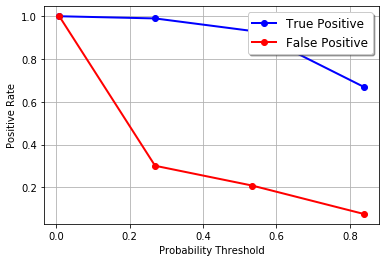

[1.83765948 0.83765948 0.53419726 0.26935484 0.00842044]
[0.         0.59439791 0.72300827 0.68901787 0.        ]


In [22]:
#2E:
train['PROBABILITY'] = train.iloc[:].apply(lambda x: getPredictedProbability(x), axis=1)
threshold = num_commercial/(num_private + num_commercial)

# Get misclassification rate
Y_train = np.array(train['CAR_USE'])
predProbY_train = np.array(train['PROBABILITY'])
predY = np.empty_like(Y_train)
nYt = Y.shape[0]

for i in range(nYt):
    if predProbY[i] > threshold:
        predY[i] = 'Commercial'
    else:
        predY[i] = 'Private'
        
fpr, tpr, thresholds = metrics.roc_curve(Y_train, predProbY_train, pos_label = 'Commercial')

cutoff = np.where(thresholds > 1.0, np.nan, thresholds)
plt.plot(cutoff, tpr, marker = 'o', label = 'True Positive',
         color = 'blue', linestyle = 'solid', linewidth = 2, markersize = 6)
plt.plot(cutoff, fpr, marker = 'o', label = 'False Positive',
         color = 'red', linestyle = 'solid', linewidth = 2, markersize = 6)
plt.grid(True)
plt.xlabel("Probability Threshold")
plt.ylabel("Positive Rate")
plt.legend(loc = 'upper right', shadow = True, fontsize = 'large')
plt.show()

print(thresholds)
print(tpr-fpr)

## QUESTION 3

In [32]:
#3A:
# Event = Commercial, Non-event = Private
threshold = num_commercial/(num_private + num_commercial)

p_priv_ll, p_comm_ll = getProbabilities(ll_data)
p_priv_lr, p_comm_lr = getProbabilities(lr_data)
p_priv_rl, p_comm_rl = getProbabilities(rl_data)
p_priv_rr, p_comm_rr = getProbabilities(rr_data)

# revised_data = pd.concat([ll_data, lr_data, rl_data, rr_data], axis=0)
def getPredictedProbability(data):
    if data['OCCUPATION'] in ('Blue Collar', 'Student', 'Unknown'):
        if data['MAPPED_EDUCATION'] <= 0.5:
            return p_comm_ll
        else:
            return p_comm_lr
    else:
        if data['CAR_TYPE'] in ('Minivan', 'SUV', 'Sports Car'):
            return p_comm_rl
        else:
            return p_comm_rr

def goodmanKruskalsGamma(data):
    event = list(data[data['CAR_USE'] == 'Commercial']['PROBABILITY'])
    non_event = list(data[data['CAR_USE'] == 'Private']['PROBABILITY'])

    C = 0
    D = 0
    T = 0

    for e in event:
        for ne in non_event:
            if e > ne:
                C += 1
            elif e == ne:
                T += 1
            else:
                D += 1

    print(C, D, T)
    return((C-D)/(C+D))

test['PROBABILITY'] = test.iloc[:].apply(lambda x: getPredictedProbability(x), axis=1)

# Get misclassification rate
Y = np.array(test['CAR_USE'])
predProbY = np.array(test['PROBABILITY'])
predY = np.empty_like(Y)
nY = Y.shape[0]

for i in range(nY):
    if predProbY[i] > threshold:
        predY[i] = 'Commercial'
    else:
        predY[i] = 'Private'

RASE = 0.0
for i in range(nY):
    if (Y[i] == 'Commercial'):
        RASE += (1 - predProbY[i])**2
    else:
        RASE += (0 - predProbY[i])**2
RASE = np.sqrt(RASE/nY)

# Calculate the Root Mean Squared Error
Y_true = 1.0 * np.isin(Y, ['Commercial'])
RMSE = metrics.mean_squared_error(Y_true, predProbY)
RMSE = np.sqrt(RMSE)

AUC = metrics.roc_auc_score(Y_true, predProbY)
Gini = 2 * AUC - 1
accuracy = metrics.accuracy_score(Y, predY)
        
print('                  Accuracy: {:.13f}' .format(accuracy))
print('    Misclassification Rate: {:.13f}' .format(1-accuracy))
print('          Area Under Curve: {:.13f}' .format(AUC))
print('Root Average Squared Error: {:.13f}' .format(RASE))
print('   Root Mean Squared Error: {:.13f}' .format(RMSE))
print('                      Gini: {:.13f}' .format(Gini))
print('     Goodman-Kruskal Gamma: {:.13f}' .format(goodmanKruskalsGamma(test)))

                  Accuracy: 0.8540372670807
    Misclassification Rate: 0.1459627329193
          Area Under Curve: 0.9315819462838
Root Average Squared Error: 0.3072884960164
   Root Mean Squared Error: 0.3072884960164
                      Gini: 0.8631638925676
1372467 40896 129300
     Goodman-Kruskal Gamma: 0.9421295166210


/Users/jasonyeoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
#3B:
ks_threshold = 0.53419726 
ks_predY = np.empty_like(Y)
for i in range(nY):
    if predProbY[i] > ks_threshold:
        ks_predY[i] = 'Commercial'
    else:
        ks_predY[i] = 'Private'

print(metrics.accuracy_score(Y, ks_predY))
print(1.0 - metrics.accuracy_score(Y, ks_predY))

0.8540372670807453
0.14596273291925466


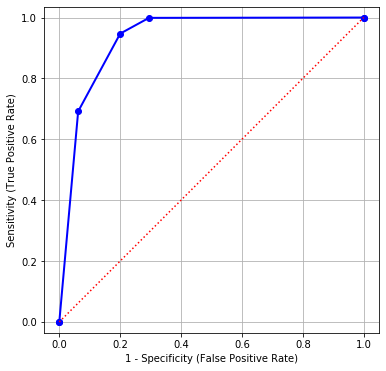

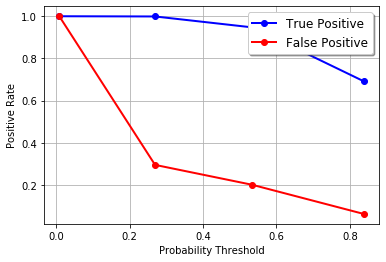

[1.83765948 0.83765948 0.53419726 0.26935484 0.00842044]
[0.         0.62965664 0.74707891 0.70428473 0.        ]


In [29]:
# Generate the coordinates for the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(Y, predProbY, pos_label = 'Commercial')

# Add two dummy coordinates
OneMinusSpecificity = np.append([0], fpr)
Sensitivity = np.append([0], tpr)

OneMinusSpecificity = np.append(OneMinusSpecificity, [1])
Sensitivity = np.append(Sensitivity, [1])

# Draw the ROC curve
plt.figure(figsize=(6,6))
plt.plot(OneMinusSpecificity, Sensitivity, marker = 'o',
         color = 'blue', linestyle = 'solid', linewidth = 2, markersize = 6)
plt.plot([0, 1], [0, 1], color = 'red', linestyle = ':')
plt.grid(True)
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.axis("equal")
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(Y, predProbY, pos_label = 'Commercial')

cutoff = np.where(thresholds > 1.0, np.nan, thresholds)
plt.plot(cutoff, tpr, marker = 'o', label = 'True Positive',
         color = 'blue', linestyle = 'solid', linewidth = 2, markersize = 6)
plt.plot(cutoff, fpr, marker = 'o', label = 'False Positive',
         color = 'red', linestyle = 'solid', linewidth = 2, markersize = 6)
plt.grid(True)
plt.xlabel("Probability Threshold")
plt.ylabel("Positive Rate")
plt.legend(loc = 'upper right', shadow = True, fontsize = 'large')
plt.show()

print(thresholds)
print(tpr-fpr)

In [33]:
goodmanKruskalsGamma(test)

1372467 40896 129300


0.9421295166209954